# Q3: Multi-Layer Perceptrons

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import shap

In [4]:
# Global seeds
np.random.seed(42)
random.seed(42)

In [5]:
# Load CSVs
X_train = pd.read_csv("X_train_scaled.csv")
X_test = pd.read_csv("X_test_scaled.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

## Q3.1 Implement MLP

In [6]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32]):
        super(SimpleMLP, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], 1))  # binary classification output
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x).squeeze()

In [7]:
def train_mlp_pytorch(
    X_train, X_val, y_train, y_val, X_test, y_test,
    hidden_dims=[64, 32], epochs=100, lr=0.001, batch_size=32, random_seed=42, patience=10):

    torch.manual_seed(random_seed)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).squeeze()
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).squeeze()
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).squeeze()

    # Create model
    model = SimpleMLP(input_dim=X_train.shape[1], hidden_dims=hidden_dims)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # To store metrics
    losses = []
    val_accuracies = []

    # Early stopping setup
    best_val_accuracy = 0
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Save loss
        losses.append(loss.item())

        # Validation evaluation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_probs = torch.sigmoid(val_outputs)
            val_preds = (val_probs >= 0.5).int()

            val_accuracy = (val_preds == y_val_tensor.int()).float().mean().item()
            val_accuracies.append(val_accuracy)

        # Early stopping logic
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
            best_model_state = model.state_dict()  # Save best model
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs).")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    # Plot training loss and validation accuracy
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(range(1, len(losses) + 1), losses, label='Training Loss', color='tab:blue', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.axvline(x=best_epoch + 1, color='red', linestyle='--', label='Best Epoch')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy', color='tab:green')
    ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='tab:green', marker='x')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    fig.tight_layout()
    plt.title('Training Loss and Validation Accuracy (MLP with Early Stopping)')
    fig.legend(loc="upper left", bbox_to_anchor=(0.15,0.85))
    plt.grid()
    plt.show()

    print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}")


    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_probs = torch.sigmoid(test_outputs)
        y_pred_test = (test_probs >= 0.5).int()

    # Metrics
    y_pred_test = y_pred_test.cpu().numpy()
    y_true_test = y_test_tensor.cpu().numpy()

    print("\nFinal Test Set Performance:")
    print(classification_report(y_true_test, y_pred_test))
    f1 = f1_score(y_true_test, y_pred_test)
    balanced_acc = balanced_accuracy_score(y_true_test, y_pred_test)
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test Balanced Accuracy: {balanced_acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix (Test Set - MLP)")
    plt.show()

    return model, losses, val_accuracies


Epoch [20/100], Loss: 0.6640, Val Accuracy: 0.6327
Epoch [40/100], Loss: 0.6216, Val Accuracy: 0.7347
Epoch [60/100], Loss: 0.5498, Val Accuracy: 0.8095
Early stopping at epoch 76 (no improvement for 10 epochs).


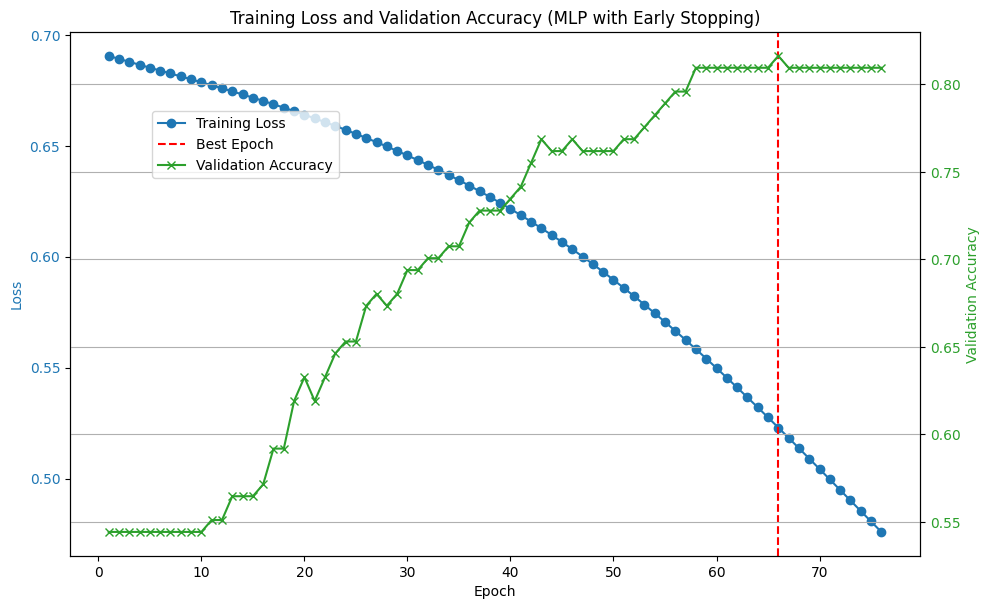

Best Validation Accuracy: 0.8163 at epoch 66

Final Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.75      0.74      0.75        74
         1.0       0.83      0.84      0.83       110

    accuracy                           0.80       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.80      0.80      0.80       184

Test F1 Score: 0.8326
Test Balanced Accuracy: 0.7898


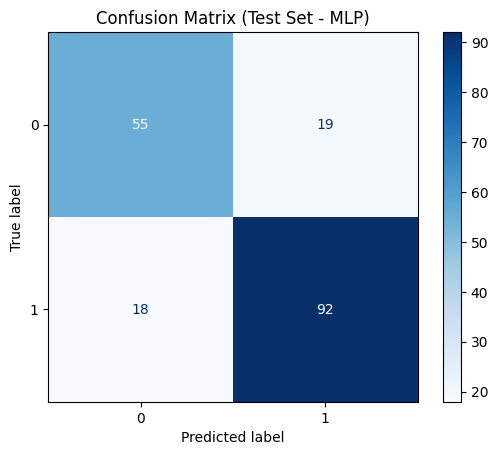

In [8]:
# Split original training into train/val
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Train + Evaluate
model, losses, val_accuracies = train_mlp_pytorch(
    X_train_sub, X_val, y_train_sub, y_val,
    X_test, y_test,
    hidden_dims=[64, 32], epochs=100, lr=0.0005, patience=10
)


## Question 3.2 Visualization of SHAP values

In [9]:
model.eval()

def model_wrapper(X):
    with torch.no_grad():
        return model(torch.tensor(X, dtype=torch.float32)).numpy()

In [10]:
# Background data for SHAP 
# background = X_train_sub.sample(100, random_state=42).values  # shape: (100, 15)
background = X_train_sub.values 


# Create the explainer
explainer = shap.Explainer(model_wrapper, background)

# Sample test data for SHAP
# X_test_array = X_test.sample(50, random_state=42)
# shap_values = explainer(X_test_array)

shap_values = explainer(X_test)

PermutationExplainer explainer: 185it [05:31,  1.81s/it]                         


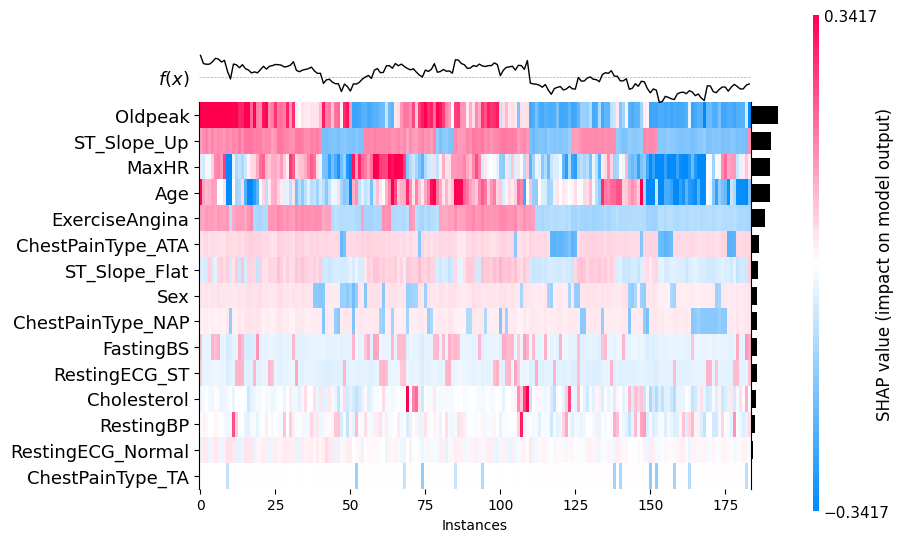

<Axes: xlabel='Instances'>

In [12]:
shap.plots.heatmap(shap_values, max_display=20, show=True)


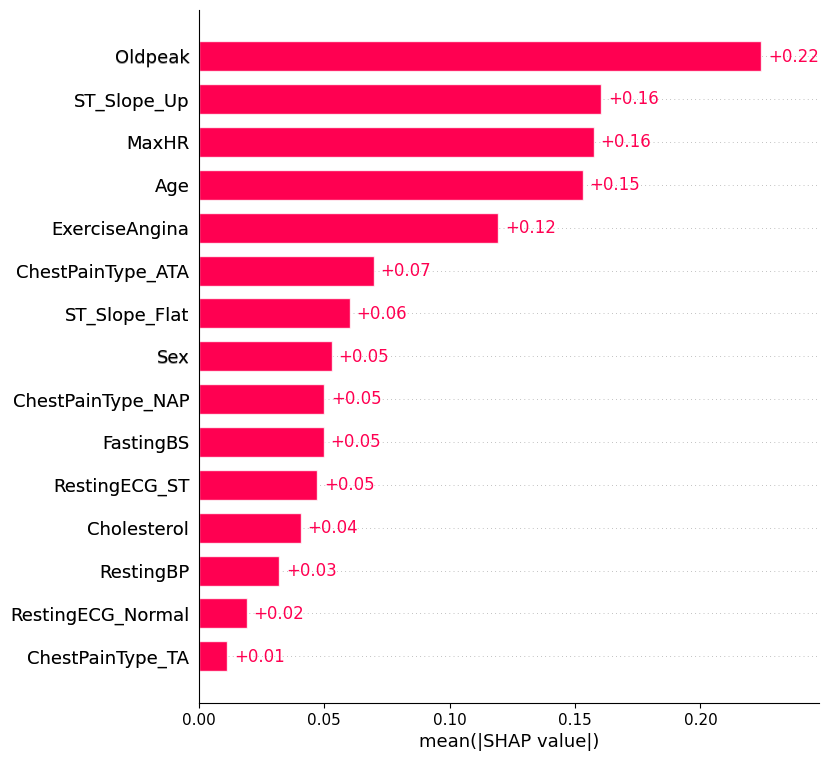

In [13]:
shap.plots.bar(shap_values, max_display=20, show=True)

/tmp/ipykernel_2653767/1859656706.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, max_display=15)


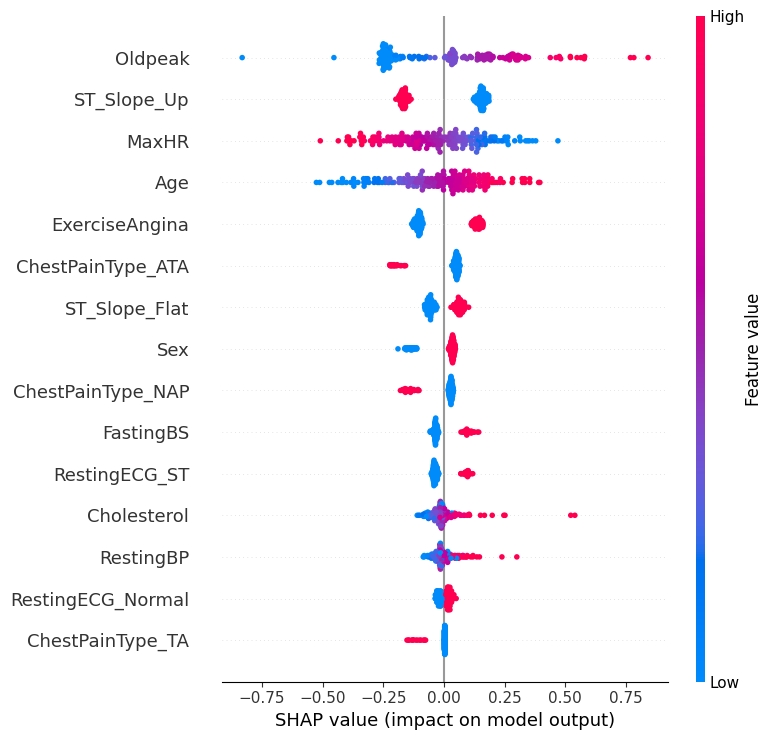

In [14]:
shap.summary_plot(shap_values, max_display=15)

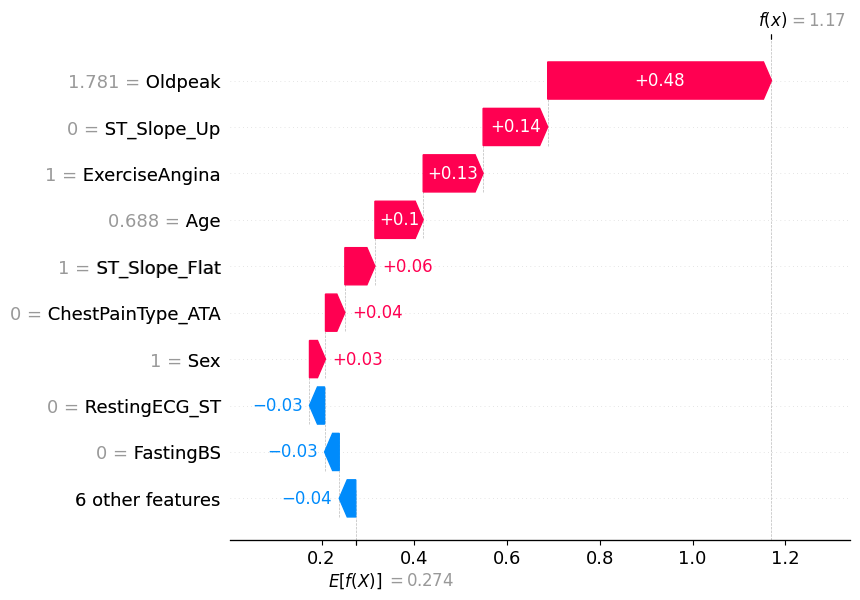

In [13]:
shap.plots.waterfall(shap_values[0])


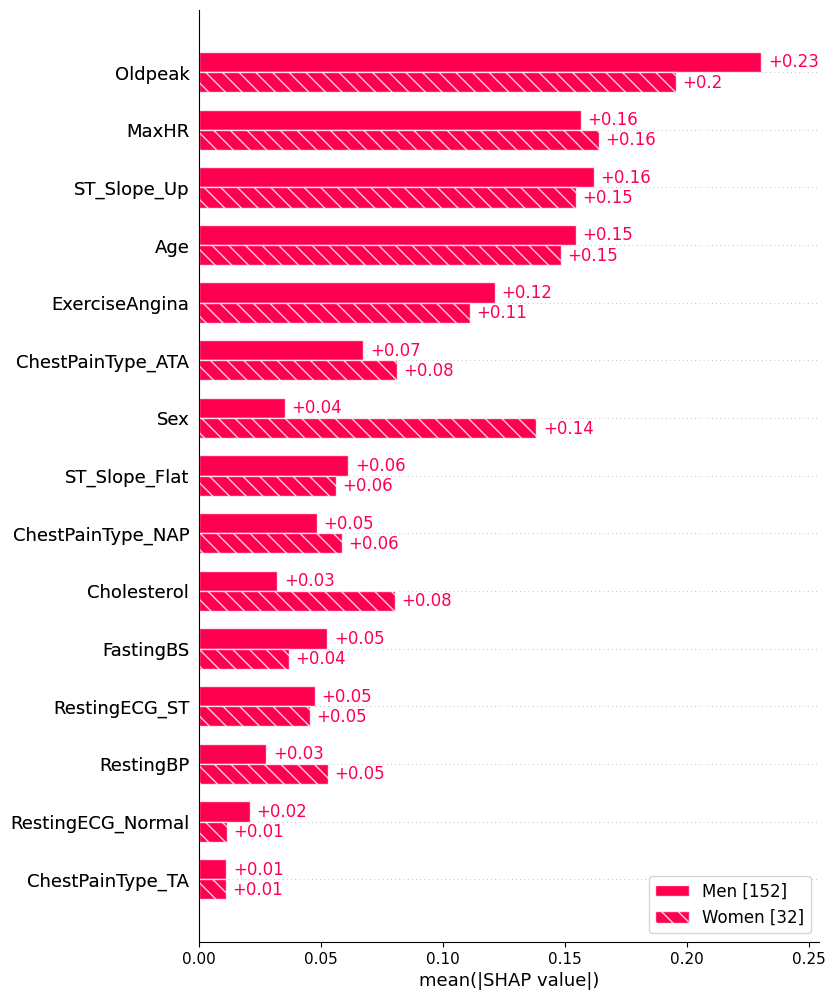

In [15]:
sex = ["Women" if shap_values[i, "Sex"].data == 0 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0), max_display=20, show=True)

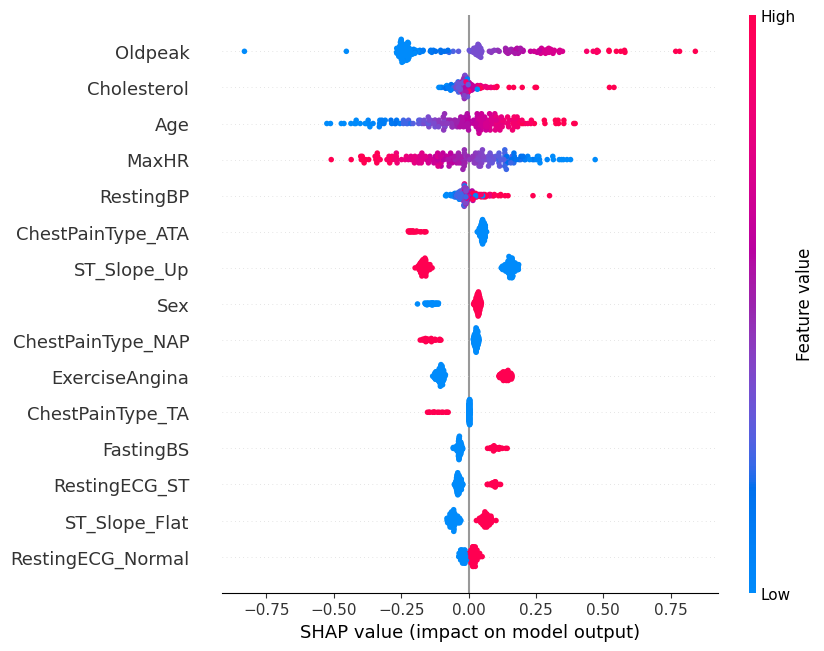

In [16]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), max_display=20, show=True)


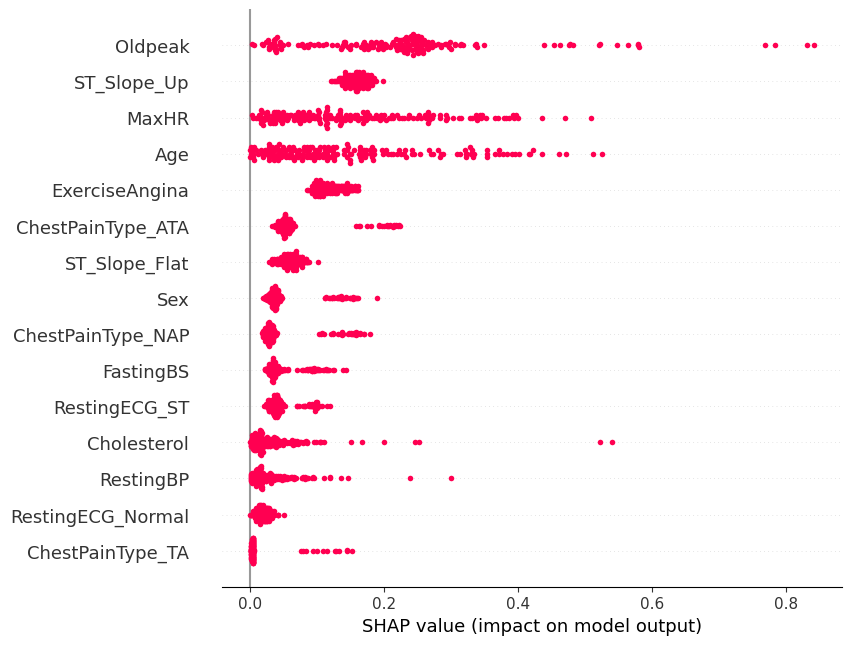

In [17]:
shap.plots.beeswarm(shap_values.abs, color="shap_red", max_display=20, show=True)


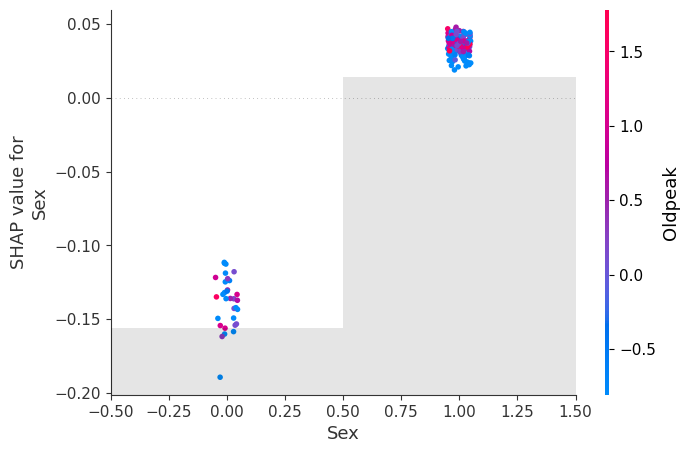

In [19]:
shap.plots.scatter(shap_values[:, "Sex"], color=shap_values[:, "Oldpeak"])


In [35]:
outputs[outputs > 0.8].shape

(60,)

In [ ]:
y_test.to_numpy().shape

,HeartDisease
0,1
1,1
2,1
3,1
4,1
...,...
179,0
180,0
181,0
182,1


In [47]:
outputs = model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()
predictions = (outputs >= 0.5).astype(int)  # Convert to binary

y_test_array = y_test.to_numpy().flatten()

# Find indices where predictions are correct
correct_indices = np.where(predictions == y_test_array)[0]

# From those, filter positives and negatives
correct_positive_indices = correct_indices[y_test_array[correct_indices] == 1]
correct_negative_indices = correct_indices[y_test_array[correct_indices] == 0]

# Randomly select two correctly predicted positives and negatives
random_pos_idx = np.random.choice(correct_positive_indices, size=2, replace=False)
random_neg_idx = np.random.choice(correct_negative_indices, size=2, replace=False)

# Combine the selected indices
selected_indices = np.concatenate([random_pos_idx, random_neg_idx])

Test if they actually also positive/negative:

In [48]:
X_test.iloc[random_pos_idx]

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,FastingBS,ExerciseAngina,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
175,-0.374220,0.654968,-0.864406,-0.401606,0.024061,1,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
43,0.900384,-0.960164,0.288463,-0.322609,1.503509,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [49]:
y_test.iloc[random_neg_idx]

,HeartDisease
15,0
67,0


In [50]:
X_test.iloc[random_neg_idx]

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,FastingBS,ExerciseAngina,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
15,0.156865,0.042331,-1.151666,-0.006619,-0.623197,1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
67,-0.905304,-0.960164,0.284633,1.928817,-0.808128,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [51]:
y_test.iloc[bottom2_idx]

,HeartDisease
28,0
97,0


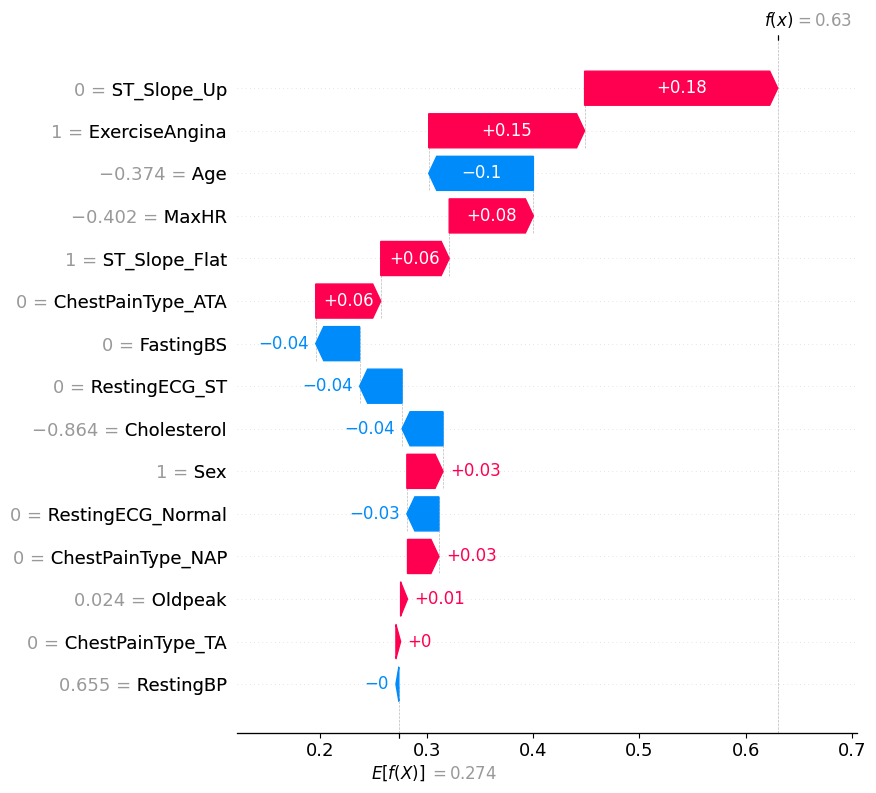

None

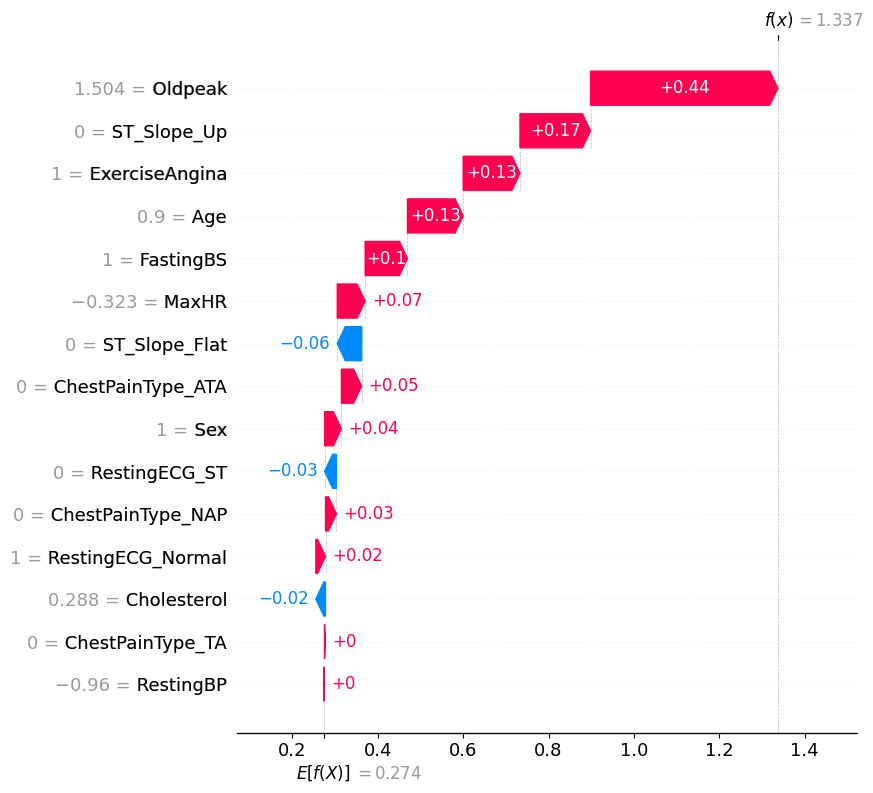

None

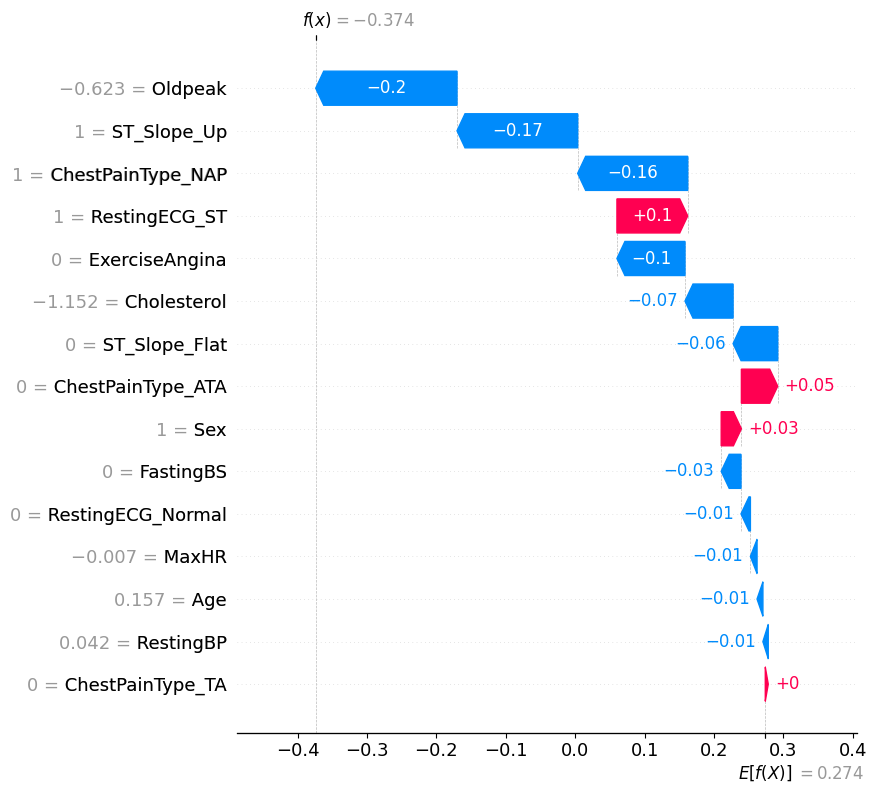

None

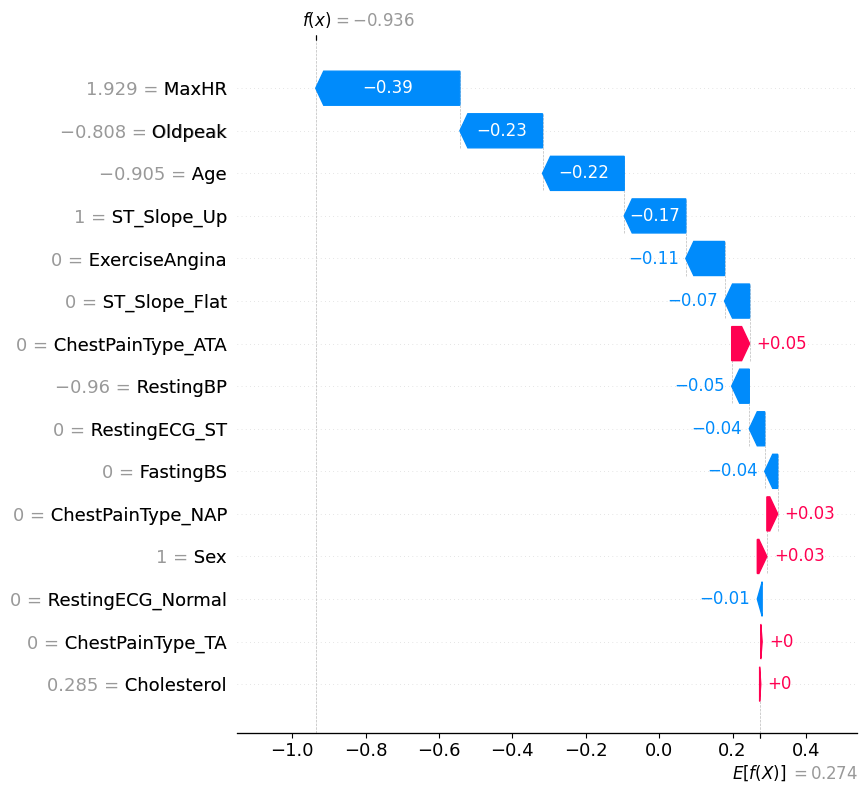

None

In [53]:
# Plot force plots
shap.initjs()
for idx in selected_indices:
    display(shap.plots.waterfall(shap_values[idx], max_display=20, show=True
    ))
    
